This response has been significantly modified from its original form. The flaws of my original response will be discussed below, but if you would like to see rouhgly what this response looked like before I made the big edit, take a look at the following notebook: https://nbviewer.jupyter.org/github/dmarx/data_generation_demo/blob/54be78fb5b68218971d2568f1680b4f783c0a79a/demo.ipynb

TL;DR: Use a KDE (or the procedure of your choice) to approximate $P(X)$, then use MCMC to draw samples from $P(X|Y) = P(Y|X)P(X)$, where $P(Y|X)$ is given by your model. From these samples, you can estimate the "optimal" $X$ by fitting a second KDE to the sampels you generated and selecting the observation that maximizes the KDE as your maximum a posteriori (MAP) estimate.

## Maximum Likelihood Estimation

In my original response, the technique I suggested was to use MCMC to perform maximum likelihood estimation. Generally, MLE is a good approach to finding the "optimal" solutions to conditional probabilities, but we have a problem here: because we're using a discriminative model (a random forest in this case) our probabilities are being calculated relative to decision boundaries. It doesn't actually make sense to talk about an "optimal" solution to a model like this because once we get far enough away from the class boundary, the model will just predict ones or zeros for everything. If we have enough classes some of them might be completely "surrounded" in which case this won't be a problem, but classes on the boundary of our data will be "maximized" by values that aren't necessarily feasible.

To demonstrate, I'm going to leverage some convenience code you can find [here](https://github.com/dmarx/data_generation_demo/blob/master/generative_sampler.py), which provides the `GenerativeSampler` class which wraps code from my original response, some additional code for this better solution, and some additional features I was playing around with (some which work, some which don't) which I probably won't get into here.

In [12]:
from generative_sampler import GenerativeSampler

Additionally, instead of generating random high dimensional data, I'll use the iris data which is more familiar and easier to visualize.

In [13]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

np.random.seed(123)

iris = load_iris()
X, y = iris.data, iris.target
RFC = RandomForestClassifier(n_estimators=80, oob_score=True)
_ = RFC.fit(X, y)

Let's use MCMC to explore the distribution of observations which maximize the likelihood $P(Y=\text{'virginica'}|X)$ given by our random forest and see what happens. Full disclosure, I modified the likelihood slightly: rather than just using the raw probability scores given by the model, I collapse the score to near 0 if the model doesn't classify an observation according to our target class.

In [27]:
#sampler.prior(X[0,:])
sampler.log_prior(X[0,:])

TypeError: 'NoneType' object is not callable

In [24]:
sampler = GenerativeSampler(model=RFC, X=X, y=y, target_class=0, prior=None, class_err_prob=0.05, rw_std=.05, verbose=True)
samples = sampler.run_chain(n=1000)

[2018-01-04 17:06:03] Ensuring model fitted
[2018-01-04 17:06:03] Generating samples
[2018-01-04 17:06:03] Selecting an x0
[2018-01-04 17:06:03] Determining class_id
[2018-01-04 17:06:03] Ensuring model fitted


TypeError: 'NoneType' object is not callable

There's probably a way to do this with PyMC3 or something like that, but I don't know my way around that library so I just used a "homebrew" MCMC implementation I found on github (https://gist.github.com/alexsavio/9ecdc1279c9a7d697ed3):

In [3]:

# via https://gist.github.com/alexsavio/9ecdc1279c9a7d697ed3
def metropolis(f, proposal, old):
    """
    basic metropolis algorithm, according to the original,
    (1953 paper), needs symmetric proposal distribution.
    """
    new = proposal(old)
    alpha = np.min([f(new)/f(old), 1])
    u = np.random.uniform()
    # _cnt_ indicates if new sample is used or not.
    cnt = 0
    if (u < alpha):
        old = new
        cnt = 1
    return old, cnt

def run_chain(chainer, f, proposal, start, n, take=1):
    """
    _chainer_ is one of Metropolis, MH, Gibbs ...
    _f_ is the unnormalized density function to sample
    _proposal_ is the proposal distirbution
    _start_ is the initial start of the Markov Chain
    _n_ length of the chain
    _take_ thinning
    """
    count = 0
    samples = [start]
    for i in range(n):
        start, c = chainer(f, proposal, start)
        count = count + c
        if i%take is 0:
            samples.append(start)
    return samples, count

Now that we have all the pieces in place, let's generate some samples from p(X|Y=0):

In [4]:
samples, _ = run_chain(chainer=metropolis,
                 f=class_cond_prob,
                 proposal=lambda old: old + np.random.randn(1,10),
                 start=X[y==0,:][0,:],
                 n=10000,
                 take=1
                 )

Let's sanity check our procedure by making sure most of our observations get classified the way we want:

In [5]:
burnin=1000
samples = np.concatenate(samples[burnin:])
y_pred = RFC.predict(samples)
np.mean(y_pred==0) # 0.57

0.74980557715809359


57% might seem low, but remember: if we were generating random samples we'd expect this proportion to be around 20% (because we have 5 classes), so this is actually pretty reasonable. We could probably improve this a bit by playing with the proposal distribution, thinning, burnin, or maybe even just cranking up the number of samples we draw (but I'm satisfied with this proof-of-concept). 

*(EDIT: the step size is too big. I tried reducing the proposal variance from 1 to 1/10 and that alone caused the correctly classified proportion to jump to 72%. I'll probably tune this a bit more later, but I didn't want to have to redo all the plots so I'm just adding this note for now)*

*(EDIT2: Actually, a better solution is to modify the likelihood to collapse the probability of candidates that don't get classified correctly. Will post updated code shortly)*

If we want, we could completely constrain our attention to samples that actually get classified the way we want (which I think makes sense in the context of the question):

In [6]:
pos_samples = samples[y_pred==0,:]

Or be even stricter and only keep samples that had really high likelihood scores, say the top 10%:

In [7]:
probs = RFC.predict_proba(pos_samples)[:,0]
top_ix = np.where(probs >= np.percentile(probs, 90))[0]
top_samples = pos_samples[top_ix, :]

Finally, let's visualize the distributions of our respective features, since presumably that really what you're interested in here:

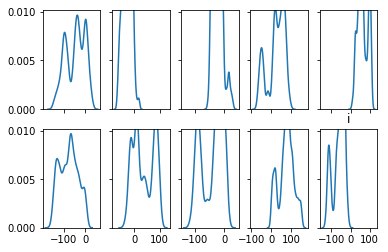

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

f, axes = plt.subplots(2, 5, sharex='col', sharey='row')
axes = np.concatenate(axes)
for i in range(10):
    sns.kdeplot(samples[:,i], ax=axes[i])
    plt.title("i")
plt.show()

And here're the distributions for just our top 10% of samples

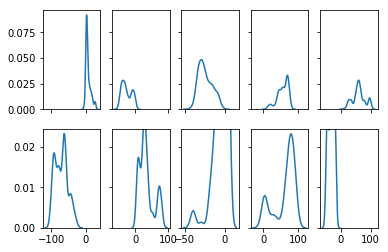

In [9]:
f, axes = plt.subplots(2, 5, sharex='col', sharey='row')
axes = np.concatenate(axes)
for i in range(10):
    sns.kdeplot(top_samples[:,i], ax=axes[i])
plt.show()

Now, be careful how you use this information. Keep in mind: these are marginal densities, so they aren't giving us information about potentially important interactions. Because we generated the training data, we know that this class is actually a spherical (gaussian) cluster, but the random forest doesn't know that and may not be representing p(X|Y) so cleanly. We should suspect that this is the case because of the appearance of multimodal distributions in those feature distribution plots. If we visualize the 2D PCA projection of our top samples, we can see that the random forest identified several distinct high probability regions for this class, although we know apriori that there should really just be one (at the mean of the gaussian):

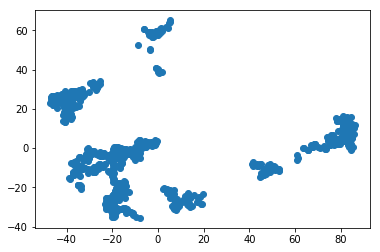

In [10]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
X_r = pca.fit_transform(top_samples)

plt.scatter(X_r[:,0], X_r[:,1])
plt.show()